##### Imports

In [1]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import argparse
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import sys
import matplotlib

tfl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

##### Model Code

In [2]:
class DiffusionModelArch:
    def __init__(self, input_size, beta_schedule):
        self.T = len(beta_schedule)
        self.input_size = input_size
        self.t_probs = [1 / self.T for _ in range(self.T)]
        self.z_theta_model = self.build_z_theta_model(self.input_size)
        self.t_distribution = tfd.OneHotCategorical(
            probs=self.t_probs, dtype=tf.float32
        )
        self.iso_normal = tfd.Normal(
            loc=tf.zeros(input_size), scale=tf.ones(input_size)
        )
        self.eps_distribution = self.iso_normal
        alpha_schedule = 1 - beta_schedule
        self.alpha_schedule = tf.convert_to_tensor(alpha_schedule, dtype=tf.float32)
        self.beta_schedule = tf.convert_to_tensor(beta_schedule, dtype=tf.float32)
        self.sigma_schedule = tf.sqrt(self.beta_schedule)
        self.alpha_bars = tf.convert_to_tensor(
            np.cumprod(self.alpha_schedule), dtype=tf.float32
        )
        self.loss_fn = tf.keras.losses.mse
        self.X_T_distribution = self.iso_normal

    def build_z_theta_model(
        self,
        x_input_size,
        n_units=100,
        n_layers=3,
    ):
        # model takes two inputs x_t and t
        output_size = x_input_size
        x_input_layer = tfl.Input(shape=x_input_size)
        t_layer = tfl.Input(shape=1)
        t_scaled = tfl.Lambda(lambda x: x / self.T)(t_layer)
        cur_layer = tfl.Concatenate()([x_input_layer, t_scaled])
        for _ in range(n_layers):
            cur_layer = tfl.Dense(n_units, activation="relu")(cur_layer)
            cur_layer = tfl.Dropout(rate=0.5)(cur_layer)
        out_layer = tfl.Dense(output_size, activation="linear")(cur_layer)
        return tf.keras.Model(inputs=[x_input_layer, t_layer], outputs=[out_layer])

    def calculate_error(self, X_input):
        this_batch_size = X_input.shape[0]
        eps = self.eps_distribution.sample(this_batch_size)
        t_sub_one_hot = self.t_distribution.sample(this_batch_size)
        selected_alpha_bars = tf.expand_dims(
            tf.tensordot(t_sub_one_hot, self.alpha_bars, 1), axis=1
        )
        sqrt_a = tf.sqrt(selected_alpha_bars)
        sqrt_n_a = tf.sqrt(1 - selected_alpha_bars)
        ts = tf.expand_dims(tf.argmax(t_sub_one_hot, axis=1), axis=1) + 1
        noise_input = sqrt_a * X_input + sqrt_n_a * eps
        model_input = [noise_input, ts]

        model_pred = self.z_theta_model(model_input)
        loss_value = self.loss_fn(eps, model_pred)

        return loss_value

    def sample(self, num_samples, save_steps=100):
        X_T = self.iso_normal.sample(num_samples)
        save_dict = {self.T: X_T}

        cur_X = X_T
        for t in np.arange(self.T, 0, -1):
            if t > 1:
                z = self.iso_normal.sample(num_samples)
            else:
                z = tf.zeros((num_samples, self.input_size))

            t_sub_one = t - 1
            alpha = self.alpha_schedule[t_sub_one]
            alpha_bar = self.alpha_bars[t_sub_one]
            sigma = self.sigma_schedule[t_sub_one]
            t_input = tf.broadcast_to(t, (num_samples, 1))
            model_input = [cur_X, t_input]
            model_pred = self.z_theta_model(model_input)
            cur_X = (1 / tf.sqrt(alpha)) * (
                cur_X - ((1 - alpha) / (tf.sqrt(1 - alpha_bar))) * model_pred
            ) + sigma * z
            if t % save_steps == 0:
                save_dict[t] = cur_X
        return cur_X, save_dict

##### Building the data

In [3]:
n_samples=10000
noise=0.05
swiss_roll, _ = make_swiss_roll(n_samples, noise=noise)
X = np.stack((swiss_roll[:, 0], swiss_roll[:, 2]), axis=1).astype(np.float32)
X = X / 1.  # scale, the relative scale between the data and the noise will affect how well the model performs
input_size = 2


##### Build the Model

In [4]:
num_T = 1000
beta_schedule = np.linspace(1e-4, 0.02, num_T)
dm = DiffusionModelArch(input_size=X.shape[1], beta_schedule=beta_schedule)

2022-08-28 21:18:12.893310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 21:18:12.898065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 21:18:12.898232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 21:18:12.898690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

##### Training Settings

In [5]:
batch_size = 16
shuffle_batch_size = 1000
train_samples = int(0.8 * n_samples)
X_train = X[:train_samples]
X_test = X[train_samples:]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(X_train)
    .shuffle(shuffle_batch_size)
    .padded_batch(batch_size, drop_remainder=True)
)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)


##### Training Code

In [6]:
optimizer = tf.keras.optimizers.Adam()

best_val_loss = np.inf
best_weights = None
patience = 5
curr_patience = 0
stop_flag = False
epoch_idx = 0
while not stop_flag:
    batch_idx = 0
    for X_batch in train_dataset:
        with tf.GradientTape() as tape:
            loss_value = dm.calculate_error(X_batch)

        batch_idx += 1
        gradients = tape.gradient(loss_value, dm.z_theta_model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, dm.z_theta_model.trainable_weights))
    val_losses = []
    for X_test in test_dataset:
        loss_value = dm.calculate_error(X_test)
        mean_loss = tf.reduce_mean(loss_value)

        val_losses.append(mean_loss)
    mean_val_loss = tf.reduce_mean(val_losses).numpy()
    print(f"\r>> mean_loss {mean_val_loss}, epoch: {epoch_idx}")
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        curr_patience = 0
        best_weights = dm.z_theta_model.get_weights()
    else:
        curr_patience += 1
        if curr_patience >= patience:
            stop_flag = True
    epoch_idx += 1

dm.z_theta_model.set_weights(best_weights)

>> mean_loss 0.7245957255363464, epoch: 0
>> mean_loss 0.687894880771637, epoch: 1
>> mean_loss 0.6556811332702637, epoch: 2
>> mean_loss 0.628447413444519, epoch: 3
>> mean_loss 0.5810931921005249, epoch: 4
>> mean_loss 0.6003655791282654, epoch: 5
>> mean_loss 0.5792195796966553, epoch: 6
>> mean_loss 0.605901300907135, epoch: 7
>> mean_loss 0.5586485862731934, epoch: 8
>> mean_loss 0.5661386847496033, epoch: 9
>> mean_loss 0.5606896877288818, epoch: 10
>> mean_loss 0.5692709684371948, epoch: 11
>> mean_loss 0.5130817294120789, epoch: 12
>> mean_loss 0.5638729333877563, epoch: 13
>> mean_loss 0.5323300957679749, epoch: 14
>> mean_loss 0.5106557607650757, epoch: 15
>> mean_loss 0.5122318267822266, epoch: 16
>> mean_loss 0.5183330774307251, epoch: 17
>> mean_loss 0.4857451915740967, epoch: 18
>> mean_loss 0.4528072476387024, epoch: 19
>> mean_loss 0.4940684735774994, epoch: 20
>> mean_loss 0.5384451746940613, epoch: 21
>> mean_loss 0.4686659872531891, epoch: 22
>> mean_loss 0.457745045

##### Generate samples from model

In [7]:
sample_X, result_dict = dm.sample(num_samples=300,save_steps=50)

##### View generated samples

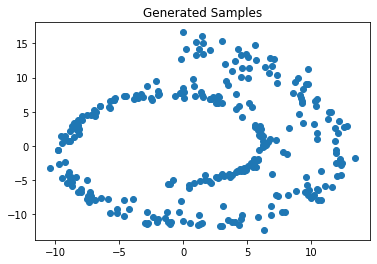

In [8]:
plt.scatter(
    sample_X[:, 0],
    sample_X[:, 1],
)
plt.title('Generated Samples')
plt.show()


##### Compare generated samples with training data

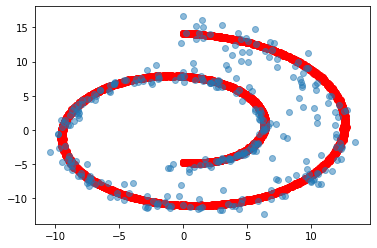

In [9]:
plt.scatter(X[:,0],X[:,1],color='red')
plt.scatter(
    sample_X[:, 0],
    sample_X[:, 1],
    alpha=0.5
)

plt.show()

##### View sample generation process

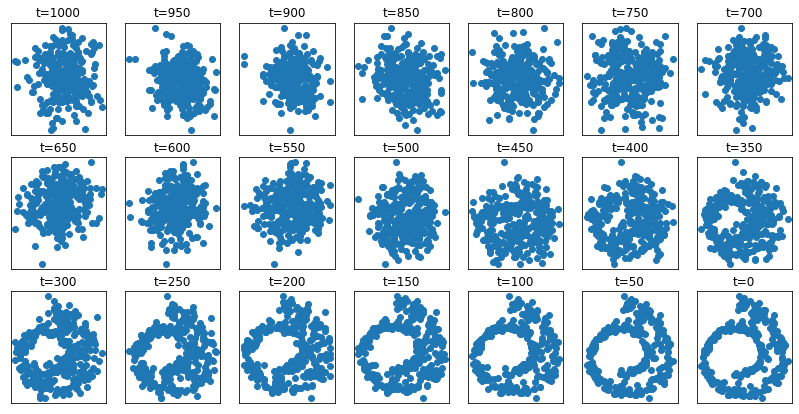

In [10]:
matplotlib.rcParams['figure.figsize'] = [14, 7]
result_dict[0] = sample_X
num_images = len(result_dict)
num_col = 7
num_rows = np.ceil(num_images/num_col).astype(np.uint8)
fig, axs = plt.subplots(num_rows, num_col)

for idx,t in enumerate(sorted(result_dict.keys(),reverse=True)):
    row_idx = idx // num_col
    col_idx = idx % num_col
    t_sample = result_dict[t]
    axs[row_idx,col_idx].scatter(t_sample[:,0],t_sample[:,1])
    axs[row_idx,col_idx].set_title(f"t={t}")
    axs[row_idx,col_idx].yaxis.set_visible(False)
    axs[row_idx,col_idx].xaxis.set_visible(False)
plt.show()